# Calculation of suitable frequency range from attentuation

**Note: add to Elara Handbook**

In this notebook, we calculate the atmospheric attenuation (that is, the effect of the atmosphere on space-to-ground power transmission) specific cases as well as the general case. We will be using these values to determine a suitable microwave range for the Elara space swarms.

In [3]:
import itur
import astropy.units as u
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt

In [369]:
# Vector graphics
%config InlineBackend.figure_format = 'svg'
# Serif text
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'stix'

## Gaseous attenuation

The first case of attenuation is the attenuation due to atmospheric gases in the atmosphere. We will do the calculations here, using the ITU-R reference model, implemented by an external library.

In [361]:
# reference conditions
rho = 7.5 * u.g / u.m**3 # water vapour density
P = 1013 * u.hPa # atmospheric pressure
T = 25 * u.deg_C # temperature 

The ITU-R model can be chosen to yield an approximate or exact solution, depending on the level of accuracy required. We will use the approximate mode for now, though once the precision is necessary, we will need to use the exact mode.

In [364]:
MODE = "approx"

In general, the attenuation is a function of both atmospheric conditions (water vapour, density, rain, dust, and cloud conditions) as well as the angle of elevation of the power satellites relative to a receiver station, which will change continuously as the power satellites orbit. We can see the effect of elevation angle on attenuation quite distinctly. For instance, with otherwise identical parameters, an elevation angle of 90 degrees (i.e. satellite directly above the receiver station) has _drastically_ lower attenuation as compared to an elevation angle of 5 degrees (i.e. satellite at the edge of the horizon relative to the receiver station:

In [249]:
Att5 = itur.gaseous_attenuation_slant_path(1, 5, rho, P, T) # for elevation angle of 5 deg
Att5

<Quantity 0.34210686 dB>

In [250]:
Att90 = itur.gaseous_attenuation_slant_path(1, 90, rho, P, T) # for elevation angle of 5 deg
Att90

<Quantity 0.02981658 dB>

In [253]:
print("For 90 deg: " + str(round((1- 10**(-(Att90/u.dB).value/10)) * 100, 2)) + "%")

For 90 deg: 0.68%


In [254]:
print("For 5 deg: " + str(round((1- 10**(-(Att5/u.dB).value/10)) * 100, 2)) + "%")

For 5 deg: 7.58%


We will enter in the conditions that result in maximum attenuation (power loss due to the atmosphere) as our **baseline value** (i.e. with the minimum elevation angle supported by the ITU-R model, which is 5 degrees). This means that this is an estimate of the worst-case power losses, which is important to design for to ensure that the system is robust.

In [367]:
el = 5 * u.deg # lowest elevation angle (nearly completely horizontal = longest distance = max attenuation)
f = np.linspace(1, 100, 1000) * u.GHz

In [365]:
Att = itur.gaseous_attenuation_slant_path(f, el, rho, P, T, mode=MODE)

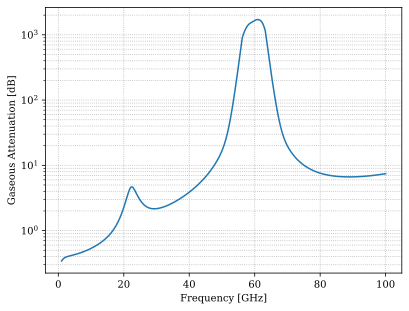

In [370]:
plt.semilogy(f, Att)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Gaseous Attenuation [dB]')
plt.grid(which='both', linestyle=':')

Note that these attenuation values are in _decibels_, which are a logarithmic unit:

In [286]:
Att.unit

Unit("dB")

To extract the raw values we make it dimensionless by dividing by `u.dB` to cancel out the units, then apply the typical log formula $\ell = 10^{-\mathrm{dB}/10}$ where $\ell$ is the percent loss in linear (instead of logarithmic) units.

In [287]:
Att_dimensionless = Att/u.dB

In [288]:
loss_linear = 1 - 10**(-Att_dimensionless/10)

We now pick the frequencies whose attenuation values that corresponds to <10% loss (which is >90% transmittance):

In [316]:
percent = u.def_unit("%", u.dimensionless_unscaled) #define new percent unit

In [320]:
# pick out the frequencies corresponding to
# attenuations with less than 10% loss
f_range = f[loss_linear <= 0.1]
# and pick out the respective attenuations
loss_percents = loss_linear[loss_linear <= 0.1] * 100 * percent

In [339]:
c = 299792458 * u.m / u.s

In [342]:
c

<Quantity 2.99792458e+08 m / s>

In [344]:
wavelengths = (c/f_range).to("cm")

In [384]:
freq_table = Table([
    np.round(f_range, 2),
    np.round(wavelengths, 2),
    np.round(loss_percents, 3)], 
    names=["Frequency", "Wavelength", "Gaseous attenuation losses (worst-case)"], 
    descriptions=None, dtype=None, meta=None)

In [351]:
freq_table

Frequency,Wavelength,Gaseous attenuation losses (worst-case)
GHz,cm,%
float64,float64,float64
1.0,29.98,7.575
1.1,27.28,7.677
1.2,25.02,7.802
1.3,23.11,7.925
1.4,21.47,8.037
1.5,20.05,8.137
1.59,18.8,8.226
1.69,17.7,8.305


Based on the gaseous attenuation, the suitable frequencies are between 1 and 6.75 GHz, corresponding approximately to 4.4 - 30 cm. We will now examine the other sources of attenuation. This includes the contribution due to rain, clouds, and scintillation (rapid changes of refractive index as electromagnetic waves pass through the atmosphere due to turbulence and other effects). While the specific modelling of each is rather complex, the full model is thankfully implemented in code so we can compute it readily.

For this, we will use the `atmospheric_attenuation_slant_path` method, which also takes into account the Earthbound receiver diameter and the latitude and longitude of the receiver. We will use two test locations for calculating the attenuation. The first is the Bering sea, located at 54.393203° N, 172.369927° W, representing (_in theory_) close to the worst-case attenuation due to its remoteness and high lattitude (which both increase atmospheric losses). The second is Hawaii, located at 19.8987° N, 155.6659° W, representing (_in theory_) close to the most favorable conditions and therefore the best-case attenuation. (See [this GPS coordinates viewer](https://www.gps-coordinates.net/) for an interactive way to view these coordinates). From this we can calculate a range of values. Note that _we are not planning to put a power receiver station at either location_. Their general location on the planet is simply a reference point for planning.

In [378]:
# Calculate other sources of attenuation (dust, rain, clouds) and also the total attenuation
# args: lat, lon, f, el, p, D
# D: earth-station antenna diameter (m)
# we will use 10m as a conservative estimate
# as attenuation is highest for small-diameter receivers
D = 10

# for lat/long. we will calculate using two values:
# 1) that of approx. the Bering sea (because further north there are basically no human settlements)
# 2) close to the equator (Hawaii)
# Note that we must set the longitude with a negative sign as
# itur expects a longitude value with respect to the east (not the west)
lat1, long1 = (54.393203, -172.369927)
lat2, long2 = (19.8987, -155.6659)

# Just like before we use 5 degree elevation anlge as it is the 
# lowest elevation = highest attenuation
# and we design for the highest-attenuation conditions as our baseline value

# This parameter controls the percentage of time the rain
# attenuation is exceeded - we want our system to work even
# in the most extreme storm conditions
R_percent = 0.5

# Bering sea location
Att_location1 = itur.atmospheric_attenuation_slant_path(lat1, long1, f, el, R_percent, D, mode=MODE)
# Hawaii location
Att_location2 = itur.atmospheric_attenuation_slant_path(lat2, long2, f, el, R_percent, D, mode=MODE)

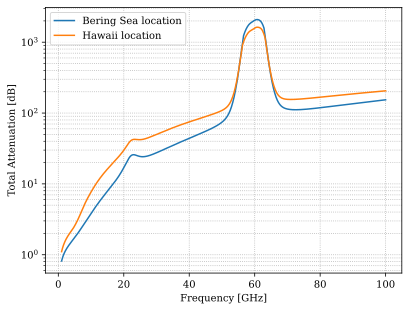

In [379]:
plt.semilogy(f, Att_location1, label="Bering Sea location")
plt.semilogy(f, Att_location2, label="Hawaii location")
plt.xlabel('Frequency [GHz]')
plt.ylabel('Total Attenuation [dB]')
plt.grid(which='both', linestyle=':')
plt.legend()
plt.show()

> It does appear that the tropical ocean may contribute to the attenuation in a way that was not entirely expected, making it so that the Hawaii test location has a higher attenuation than the Bering Sea test location at most frequencies.

We will now do the same analysis as previously, just for both the test locations:

In [388]:
def attenuation_losses(att):
    # same formula as before in modified form
    loss_linear = 1 - 10**(-Att/(10 * u.dB))
    # pick out the frequencies corresponding to
    # attenuations with less than 10% loss
    f_range = f[loss_linear <= 0.1]
    # convert to wavelengths
    wavelengths = (c/f_range).to("cm")
    # and pick out the respective attenuations
    loss_percents = loss_linear[loss_linear <= 0.1] * 100 * percent
    return f_range, wavelengths, loss_percents

In [389]:
def generate_att_table(att):
    f_range, wavelengths, loss_percents = attenuation_losses(att)
    return Table([
        np.round(f_range, 2),
        np.round(wavelengths, 2),
        np.round(loss_percents, 3)], 
    names=["Frequency", "Wavelength", "Gaseous attenuation losses (worst-case)"], 
    descriptions=None, dtype=None, meta=None)

In [390]:
Att_table_1 = generate_att_table(Att_location1)
Att_table_2 = generate_att_table(Att_location2)

In [391]:
Att_table_1

Frequency,Wavelength,Gaseous attenuation losses (worst-case)
GHz,cm,%
float64,float64,float64
1.0,29.98,7.575
1.1,27.28,7.677
1.2,25.02,7.802
1.3,23.11,7.925
1.4,21.47,8.037
1.5,20.05,8.137
1.59,18.8,8.226
1.69,17.7,8.305
